<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics

<h2>Import dataset

In [2]:
df_data = pd.read_csv('HR_comma_sep.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploratioin

In [3]:
pd.options.display.max_columns=100
df_model.head()
# df_model.Stay

# for x in df_model.Stay:
#     if df_model.Stay[x] != 0:
#       print(df_model.Stay[x])
#     else:
#       message ="no employee stay find!";
#       print(message)
#       break;

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'promotion_last_5years'

In [5]:
#choose the treatment variable
target = "left"

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<h2>Check N-uniques for non-categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [8]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
3,average_montly_hours,215
0,satisfaction_level,92
1,last_evaluation,65
4,time_spend_company,8
2,number_project,6
5,Work_accident,2
6,left,2
7,promotion_last_5years,2


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [9]:
#choose a column with hiearchy to be label encoded
cluster_cols=['average_montly_hours']

<h2>Check uniques for categorical data

In [10]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Department
sales 4140
accounting 767
hr 739
technical 2720
support 2229
management 630
IT 1227
product_mng 902
marketing 858
RandD 787

 salary
low 7316
medium 6446
high 1237


<h2>Replace Yes or No to 1 or 0

In [11]:
# df_model.Attrition.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
# df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

<h2>Rename Data

In [12]:
df_model[[treat,target]].head()

,promotion_last_5years,left
id,,
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


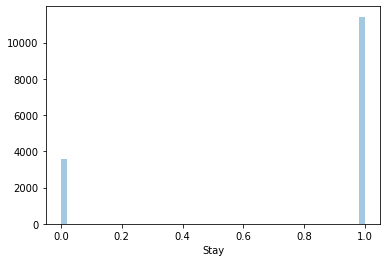

In [13]:
df_model = df_model.rename(columns={"left": "Stay"})
df_model.Stay = df_model.Stay.replace({0:1, 1:0})
sns.distplot(a=df_model.Stay, hist=True,kde=False)
# df_model = df_model.rename(columns={"promotion_last_5years": "NotOvertime"})
# treat = 'NotOvertime'


In [14]:
df_model.Stay

id
0        0
1        0
2        0
3        0
4        0
        ..
14994    0
14995    0
14996    0
14997    0
14998    0
Name: Stay, Length: 14999, dtype: int64

<h2>Invert Target Value(Churn to Stay)

In [15]:
# sns.distplot(a=df_model.Stay, hist=True,kde=False)

B.6. Inverting data from column 'Stay':[0 0 0 0 0 0 0 0 0 0] ... 
Inverted result named 'stay':[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ... 
Column 'left' has been successfully replaced by new column 'stay'!


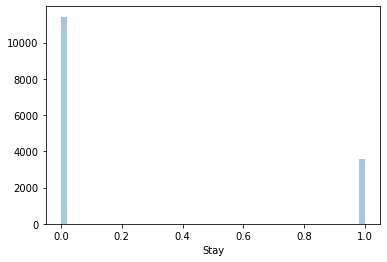

In [16]:
#setup the target column to be inverted and prepare empty array named inverted
input_data = df_model.Stay
inverted = []
print ("B.6. Inverting data from column '{}':{} ... ".format(input_data.name,df_model.Stay.values[:10]))

#inverting through all datas in column
for i in range(len(input_data)):
    inverted.append(1 - input_data[i])
print ("Inverted result named 'stay':{} ... ".format(inverted[:10]) )

#add new column stay and remove column left
df_model['Stay']=inverted
print ("Column 'left' has been successfully replaced by new column 'stay'!")

#check the result
sns.distplot(a=df_model.Stay, hist=True,kde=False)

<h2>Define columns to Label encode

In [17]:
# df_model[object_cols].head()
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [18]:
#choose a column with wide range to be clusterred
label_cols = ['salary']

<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [19]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['salary']
>>label encoding finished


,salary
id,
0,1
1,2
2,2
3,1
4,1


<h2>Data cleaning

In [20]:
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,1
1,0.80,0.86,5,262,6,0,1,0,sales,2
2,0.11,0.88,7,272,4,0,1,0,sales,2
3,0.72,0.87,5,223,5,0,1,0,sales,1
4,0.37,0.52,2,159,3,0,1,0,sales,1


In [21]:
#DROP unused columns
# df_model = df_model.drop(['Over18','StandardHours','StockOptionLevel','EmployeeCount','EmployeeNumber'],axis=1)

<h2>Cluster & One Hot Encoding

In [22]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [23]:
#preparing float columns to cluster
print('Clustering columns:',cluster_cols)
#creating the clusters
for col in cluster_cols:
    col_cluster = col + "_cluster"
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df_model[[col]])
    df_model[col_cluster] = kmeans.predict(df_model[[col]])
    #order the clusters
    df_model = order_cluster(col_cluster, col, df_model, True)
print('>>Cluster succeeded!')
#dropping columns that have been clustered
df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')

Clustering columns: ['average_montly_hours']
>>Cluster succeeded!

One Hot Encoding: ['satisfaction_level' 'last_evaluation' 'number_project'
 'time_spend_company' 'Work_accident' 'Stay' 'promotion_last_5years'
 'salary' 'average_montly_hours_cluster' 'Department_IT'
 'Department_RandD' 'Department_accounting' 'Department_hr'
 'Department_management' 'Department_marketing' 'Department_product_mng'
 'Department_sales' 'Department_support' 'Department_technical']
>>One Hot Encoding succeeded!


In [24]:
df_model

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,average_montly_hours_cluster,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
1,0.37,0.52,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
2,0.41,0.50,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
3,0.41,0.55,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
4,0.45,0.47,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.25,0.46,4,4,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1
14995,0.48,0.78,2,2,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1
14996,0.80,0.83,2,3,0,1,0,1,2,0,0,0,0,0,0,0,0,1,0
14997,0.73,0.97,6,2,0,1,0,1,2,0,0,0,0,0,0,0,1,0,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


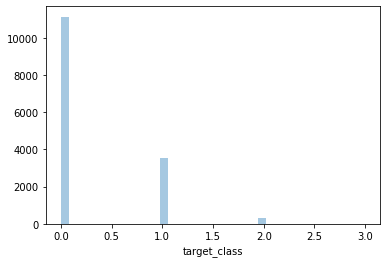

In [25]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Explore data Correlation

In [26]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
correlation = correlation.Stay.sort_values() * 100

In [27]:
pd.DataFrame(correlation)

,Stay
satisfaction_level,-38.837498
Work_accident,-15.462163
promotion_last_5years,-6.178811
Department_RandD,-4.659565
Department_management,-4.603539
Department_product_mng,-1.102915
Department_IT,-1.092483
salary,-0.129372
Department_marketing,-0.085930
last_evaluation,0.656712


<h2>Invert negative correlation(if available)

<h2>Create new dataframe for churn and uplift

In [28]:
# df_model.Stay
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

   target_class  Stay  promotion_last_5years
0             1     1                      0
1             1     1                      0
2             1     1                      0
3             1     1                      0
4             1     1                      0


<h2>Predicting Target Class(Churn Uplift)

In [29]:
#create feature set and labels
X = df_model.drop(['target_class',treat,'Stay'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class',treat,'Stay'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class',treat,'Stay'],axis=1))
# insert predicted target to uplift dataframe
df_data_uplift['p_target'] = overall_predict
df_model['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba[:,0] 
df_data_uplift['proba_CR'] = overall_proba[:,1] 
df_data_uplift['proba_TN'] = overall_proba[:,2] 
df_data_uplift['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [30]:
df_data_uplift

,target_class,Stay,promotion_last_5years,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
0,1,1,0,1,0.005015,0.994858,0.000061,0.000066,-0.951831
1,1,1,0,1,0.008185,0.991613,0.000098,0.000104,-0.952170
2,1,1,0,1,0.004385,0.978649,0.000052,0.016915,0.002843
3,1,1,0,1,0.004046,0.993040,0.000057,0.002858,-0.030712
4,1,1,0,1,0.004682,0.993485,0.000057,0.001776,-0.052758
...,...,...,...,...,...,...,...,...,...
14994,1,1,0,1,0.145870,0.853387,0.000708,0.000035,-1.614468
14995,1,1,0,1,0.208490,0.789095,0.002400,0.000015,-1.569427
14996,1,1,0,1,0.271472,0.723014,0.005468,0.000046,-1.437255
14997,1,1,0,0,0.607937,0.366873,0.025032,0.000158,-0.740167


<h2>Predicting Target (Churn Prediction)

In [31]:
df_model

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,average_montly_hours_cluster,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,target_class,p_target
0,0.38,0.53,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1
1,0.37,0.52,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1
2,0.41,0.50,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1
3,0.41,0.55,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1
4,0.45,0.47,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.25,0.46,4,4,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1,1,1
14995,0.48,0.78,2,2,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1,1,1
14996,0.80,0.83,2,3,0,1,0,1,2,0,0,0,0,0,0,0,0,1,0,1,1
14997,0.73,0.97,6,2,0,1,0,1,2,0,0,0,0,0,0,0,1,0,0,1,0


In [32]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
# df_data_lift = df_model.copy()
df_data_churn['p_stay'] = overall_predict2
df_model['p_stay'] = overall_predict2
df_data_churn['stay_score'] = overall_proba[:,1] 
df_data_churn['churn_score'] = overall_proba[:,0] 

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<h2>Rank data from Churn prediction

In [33]:
#choose treatment only
df_data_churn = df_data_churn[df_data_churn[treat] ==1]
print("Ranking data for Churn Prediction")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=True)
df_data_churn

Ranking data for Churn Prediction


,target_class,Stay,promotion_last_5years,p_stay,stay_score,churn_score
1034,2,0,1,0,0.000006,0.987258
957,2,0,1,0,0.000014,0.306865
14928,2,0,1,0,0.000022,0.075013
14578,2,0,1,0,0.000022,0.075013
956,2,0,1,0,0.000025,0.258463
...,...,...,...,...,...,...
2567,3,1,1,1,0.346096,0.002755
3497,3,1,1,1,0.372897,0.007530
9706,3,1,1,1,0.865040,0.134716
11751,3,1,1,1,0.865040,0.134716


In [34]:
df_data_churn = df_data_churn.reset_index()

<h2>Rank data from Uplift prediction

In [35]:
#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift[treat] ==1]
print("Ranking data for Churn Uplift")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=True)
df_data_uplift

Ranking data for Churn Uplift


,target_class,Stay,promotion_last_5years,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
9953,3,1,1,1,0.021987,0.977910,0.000084,0.000018,-1.597530
954,2,0,1,2,0.151412,0.147998,0.700370,0.000221,-0.987969
2399,2,0,1,2,0.050034,0.045750,0.904172,0.000044,-0.955178
2862,2,0,1,2,0.050034,0.045750,0.904172,0.000044,-0.955178
9706,3,1,1,1,0.134716,0.865040,0.000125,0.000119,-0.756558
...,...,...,...,...,...,...,...,...,...
7369,2,0,1,0,0.985587,0.000837,0.012490,0.001086,0.158228
10500,2,0,1,0,0.995425,0.000691,0.002273,0.001611,0.828372
11996,3,1,1,3,0.157713,0.000156,0.005070,0.837061,1.985980
9534,3,1,1,3,0.157713,0.000156,0.005070,0.837061,1.985980


In [36]:
sum(df_data_uplift.Stay == 0)

300

In [37]:
df_data_uplift = df_data_uplift.reset_index()

In [38]:
c=0
j=round(len(df_data_churn)/10)
k=round(len(df_model)/10)

#1
b1=200
i1=10
r1_1=(b1-i1-c)
r2_1=(-c)
r3_1=(-i1-c)
r4_1=(b1-c)

#2
b2=100
i2=10
r1_2=(b2-i2-c)
r2_2=(-c)
r3_2=(-i2-c)
r4_2=(b2-c)

#3
b3=100
i3=50
r1_3=(b3-i3-c)
r2_3=(-c)
r3_3=(-i3-c)
r4_3=(b3-c)

profit1=[]
profit2=[]
profit3=[]
profit4=[]
profit5=[]
profit6=[]

uplift1=[]
uplift2=[]
uplift3=[]
uplift4=[]
uplift5=[]
uplift6=[]

churn1=[]
churn2=[]
cum1=[]
cum2=[]
for i in range(10):
    n=i*j
    m=(i+1)*j
    
    #Churn Prediction Variables
    #true predicted churn and retained
    retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==1))
    #true predicted churn and rejected
    non_retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==0))
    #false predicted churn
    false = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.target_class[n:m]==2))
    
    #Churn Uplift Variables
    CN=sum(df_data_uplift.p_target[n:m]==0)
    CR=sum(df_data_uplift.p_target[n:m]==1)
    TN=sum(df_data_uplift.p_target[n:m]==2)
    TR=sum(df_data_uplift.p_target[n:m]==3)
    
    uplift_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==3))
    uplift_non_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==2))
    uplift_false=CR
    
    #Churn Prediction mp 
    mp1=((retained*r1_1)+(non_retained*r2_1)+(false*r3_1))/j
    mp2=((retained*r1_2)+(non_retained*r2_2)+(false*r3_2))/j
    mp3=((retained*r1_3)+(non_retained*r2_3)+(false*r3_3))/j
    
    #Churn Uplift mp
    mp4=((uplift_retained*r1_1)+(uplift_non_retained*r2_1)+(uplift_false*r3_1))/j
    mp5=((uplift_retained*r1_2)+(uplift_non_retained*r2_2)+(uplift_false*r3_2))/j
    mp6=((uplift_retained*r1_3)+(uplift_non_retained*r2_3)+(uplift_false*r3_3))/j

    profit1.append(mp1)
    profit2.append(mp2)
    profit3.append(mp3)
    profit4.append(mp4)
    profit5.append(mp5)
    profit6.append(mp6)
    
    #Churn Prediction Variables
    CP_lift = sum(df_data_churn[j:]['Stay'] ==1)
    CP_non_lift = sum(df_data_churn[j:]['Stay'] ==0)
    CU_lift = sum(df_data_uplift[j:]['Stay'] ==1)
    CU_non_lift = sum(df_data_uplift[j:]['Stay'] ==0)
    
    #Churn Prediction mpu
    mpu1=((CP_lift*r4_1)-(CP_non_lift*i1))/j
    mpu2=((CP_lift*r4_2)-(CP_non_lift*i2))/j
    mpu3=((CP_lift*r4_3)-(CP_non_lift*i3))/j
    
    #Churn Uplift mpu
    mpu4=((CU_lift*r4_1)-(CU_non_lift*i1))/j
    mpu5=((CU_lift*r4_2)-(CU_non_lift*i2))/j
    mpu6=((CU_lift*r4_3)-(CU_non_lift*i3))/j
        
    uplift1.append(mpu1)
    uplift2.append(mpu2)
    uplift3.append(mpu3)
    uplift4.append(mpu4)
    uplift5.append(mpu5)
    uplift6.append(mpu6)
    
    #employee churn rate
    churn_rate1=(TN)/j    
    churn_rate2=(TN+CN)/j    
    churn1.append(churn_rate1)
    churn2.append(churn_rate2)
    
    #employee cumulative uplift
    cum_uplift_rate1=(CR)/j    
    cum_uplift_rate2=(CR+TR)/j    
    cum1.append(churn_rate1)
    cum2.append(churn_rate2)
    
    print("\ncalculating total employees for Q{}({}-{})".format(i+1,n,m))
    print("CN=",CN)
    print("CR=",CR)
    print("TN=",TN)
    print("TR=",TR)   
    print("CP | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(retained,r1_2,non_retained,r2_2,false,r3_2,j,mp2))
    print("CU | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(uplift_retained,r1_2,uplift_non_retained,r2_2,uplift_false,r3_2,j,mp5))
#     print("CP | MPU2=(({}*{})-({}*{}) )/{}={}".format(CP_lift,r4_2,CP_non_lift,r4_2,j,mpu2))
#     print("CU | MPU2=(({}*{})-({}*{}) )/{}={}".format(CU_lift,r4_2,CU_non_lift,r4_2,j,mpu5))


calculating total employees for Q1(0-32)
CN= 3
CR= 3
TN= 26
TR= 0
CP | MP2=((0*90)+(32*0)+(32*-10) )/32=-10.0
CU | MP2=((0*90)+(0*0)+(3*-10) )/32=-0.9375

calculating total employees for Q2(32-64)
CN= 8
CR= 0
TN= 24
TR= 0
CP | MP2=((0*90)+(32*0)+(32*-10) )/32=-10.0
CU | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0

calculating total employees for Q3(64-96)
CN= 13
CR= 0
TN= 19
TR= 0
CP | MP2=((0*90)+(29*0)+(29*-10) )/32=-9.0625
CU | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0

calculating total employees for Q4(96-128)
CN= 15
CR= 0
TN= 17
TR= 0
CP | MP2=((0*90)+(32*0)+(32*-10) )/32=-10.0
CU | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0

calculating total employees for Q5(128-160)
CN= 10
CR= 0
TN= 22
TR= 0
CP | MP2=((0*90)+(32*0)+(32*-10) )/32=-10.0
CU | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0

calculating total employees for Q6(160-192)
CN= 9
CR= 0
TN= 23
TR= 0
CP | MP2=((0*90)+(32*0)+(32*-10) )/32=-10.0
CU | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0

calculating total employees for Q7(192-224)
CN= 10
CR= 0
TN= 22
TR= 0
CP |

In [39]:
cum_profit1=[]
cum_profit2=[]
cum_profit3=[]
cum_profit4=[]
cum_profit5=[]
cum_profit6=[]
for i in range(1,11):
    cum_profit1.append(sum(profit1[0:i])/i)
for i in range(1,11):
    cum_profit2.append(sum(profit2[0:i])/i)
for i in range(1,11):
    cum_profit3.append(sum(profit3[0:i])/i)
for i in range(1,11):
    cum_profit4.append(sum(profit4[0:i])/i)
for i in range(1,11):
    cum_profit5.append(sum(profit5[0:i])/i)
for i in range(1,11):
    cum_profit6.append(sum(profit6[0:i])/i)
    
cum_uplift1=[]
cum_uplift2=[]
cum_uplift3=[]
cum_uplift4=[]
cum_uplift5=[]
cum_uplift6=[]
for i in range(1,11):
    cum_uplift1.append(sum(uplift1[0:i])/i)
for i in range(1,11):
    cum_uplift2.append(sum(uplift2[0:i])/i)
for i in range(1,11):
    cum_uplift3.append(sum(uplift3[0:i])/i)
for i in range(1,11):
    cum_uplift4.append(sum(uplift4[0:i])/i)
for i in range(1,11):
    cum_uplift5.append(sum(uplift5[0:i])/i)
for i in range(1,11):
    cum_uplift6.append(sum(uplift6[0:i])/i)
    
cum_churn1=[]
cum_churn2=[]
for i in range(10):
    cum_churn1.append(sum(churn1[0:i]))
for i in range(10):
    cum_churn2.append(sum(churn2[0:i]))
    
cum_cum1=[]
cum_cum2=[]
for i in range(10):
    cum_cum1.append(sum(cum1[0:i]))
for i in range(10):
    cum_cum2.append(sum(cum2[0:i]))

Text(0.5, 1.0, 'MP - 1')

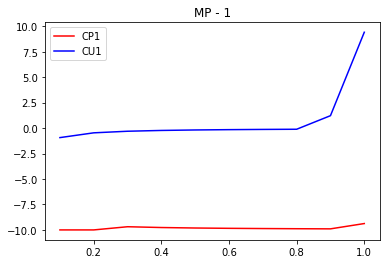

In [40]:
quantile=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
sns.lineplot(x=quantile,y=cum_profit1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_profit4, label='CU1', color='blue')
plt.title('MP - 1')

In [41]:
mean_cp=mean(cum_profit2)
mean_cu=mean(cum_profit5)
print("Predictive Method's Avg MaxProfit =", round(mean_cp,2))
print("Our Method's Avg MaxProfit =", round(mean_cu,2))
print("Our method gain {} times more MaxProfit".format(round(mean_cu/mean_cp,2)))

Predictive Method's Avg MaxProfit = -9.81
Our Method's Avg MaxProfit = 0.24
Our method gain -0.02 times more MaxProfit


Text(0, 0.5, 'Profit per customer')

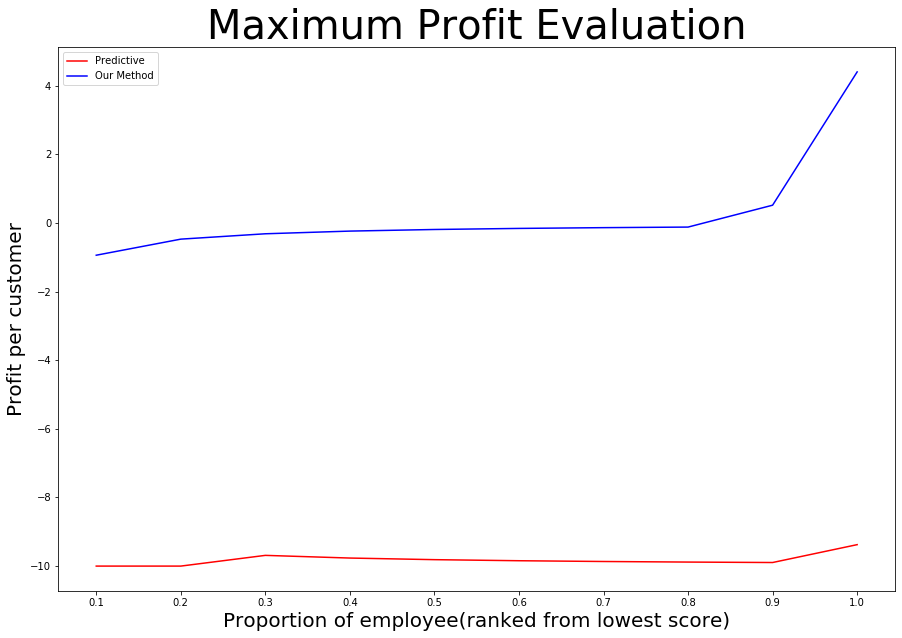

In [42]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit2, label='Predictive', color='red')
sns.lineplot(x=quantile,y=cum_profit5, label='Our Method', color='blue')
plt.title('Maximum Profit Evaluation',fontsize=40)
plt.xticks(np.arange(.1,1.1,.1))
plt.xlabel('Proportion of employee(ranked from lowest score)',fontsize=20)
plt.ylabel('Profit per customer',fontsize=20)

Text(0.5, 0, 'Proportion of employee')

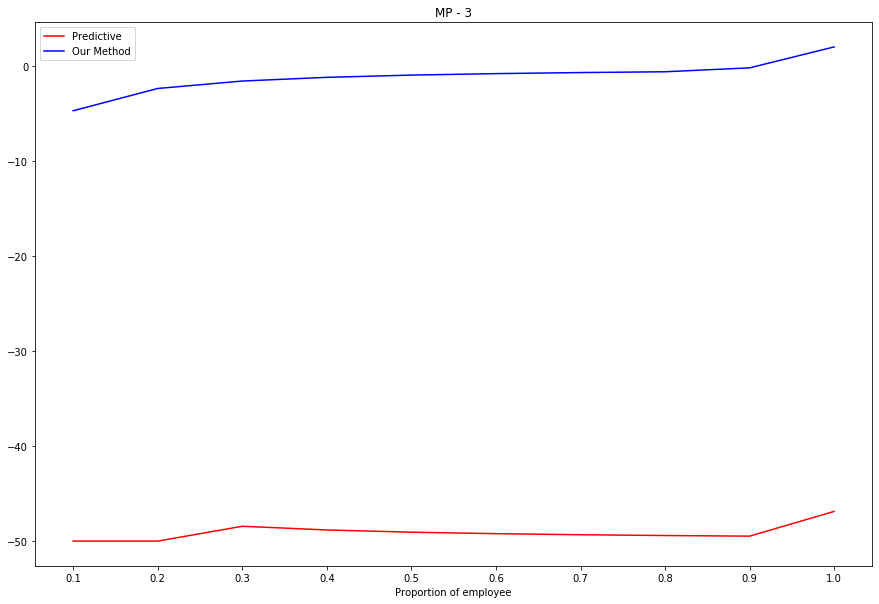

In [43]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit3, label='Predictive', color='red')
sns.lineplot(x=quantile,y=cum_profit6, label='Our Method', color='blue')
plt.title('MP - 3')
plt.xticks(np.arange(.1,1.1,.1))
plt.xlabel('Proportion of employee')

Text(0.5, 1.0, 'MP Method')

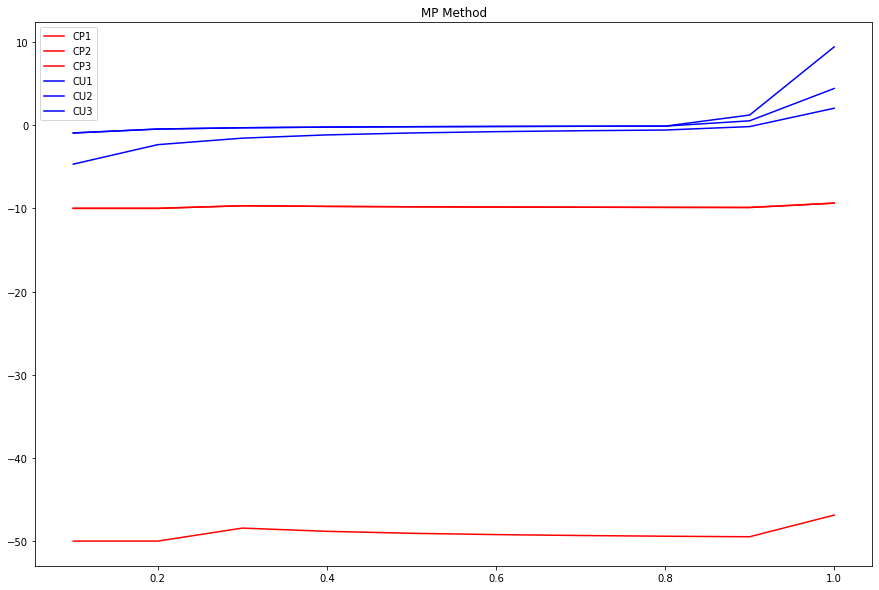

In [44]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_profit3, label='CP2', color='red')
sns.lineplot(x=quantile,y=cum_profit2, label='CP3', color='red')
sns.lineplot(x=quantile,y=cum_profit4, label='CU1', color='blue')
sns.lineplot(x=quantile,y=cum_profit5, label='CU2', color='blue')
sns.lineplot(x=quantile,y=cum_profit6, label='CU3', color='blue')
plt.title('MP Method')

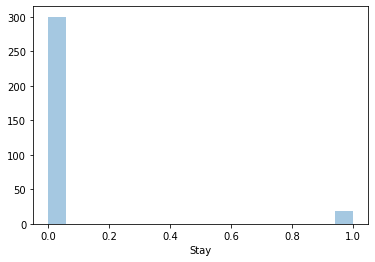

In [45]:
sns.distplot(a=df_data_churn.Stay, hist=True,kde=False)

Text(0.5, 1.0, 'MPU - 1')

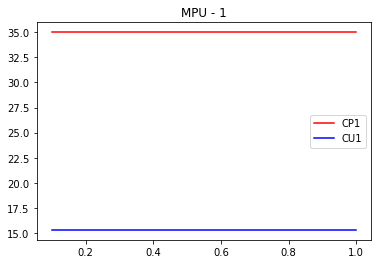

In [46]:
sns.lineplot(x=quantile,y=cum_uplift1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_uplift4, label='CU1', color='blue')
plt.title('MPU - 1')

Text(0.5, 1.0, 'MPU - 2')

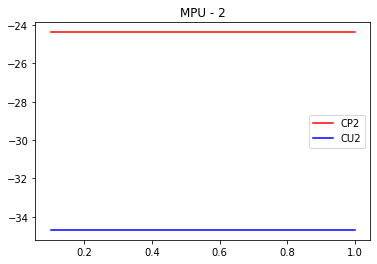

In [47]:
sns.lineplot(x=quantile,y=cum_uplift2, label='CP2', color='red')
sns.lineplot(x=quantile,y=cum_uplift5, label='CU2', color='blue')
plt.title('MPU - 2')

Text(0.5, 1.0, 'MPU - 3')

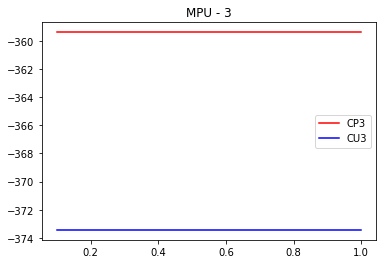

In [48]:
sns.lineplot(x=quantile,y=cum_uplift3, label='CP3', color='red')
sns.lineplot(x=quantile,y=cum_uplift6, label='CU3', color='blue')
plt.title('MPU - 3')

Text(0.5, 1.0, 'MPU Method')

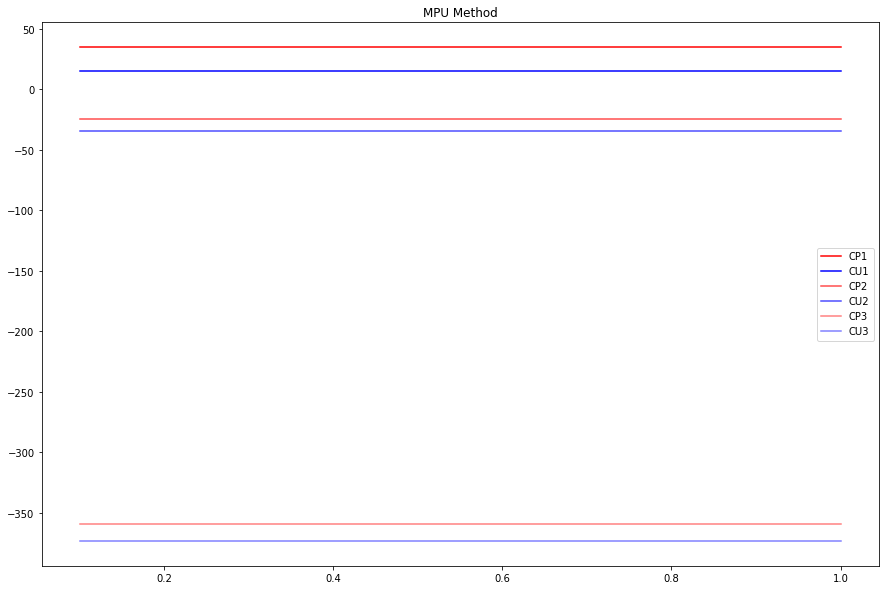

In [49]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_uplift1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_uplift4, label='CU1', color='blue')
sns.lineplot(x=quantile,y=cum_uplift2, label='CP2', color='red', alpha=0.7)
sns.lineplot(x=quantile,y=cum_uplift5, label='CU2', color='blue', alpha=0.7)
sns.lineplot(x=quantile,y=cum_uplift3, label='CP3', color='red', alpha=0.5)
sns.lineplot(x=quantile,y=cum_uplift6, label='CU3', color='blue', alpha=0.5)
plt.title('MPU Method')

In [50]:
df_data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low


<h2>Pylift

In [51]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,average_montly_hours_cluster,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,target_class,p_target,p_stay
0,0.38,0.53,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1
1,0.37,0.52,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1
2,0.41,0.50,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1
3,0.41,0.55,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1
4,0.45,0.47,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.25,0.46,4,4,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1,1,1,1
14995,0.48,0.78,2,2,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1,1,1,1
14996,0.80,0.83,2,3,0,1,0,1,2,0,0,0,0,0,0,0,0,1,0,1,1,1
14997,0.73,0.97,6,2,0,1,0,1,2,0,0,0,0,0,0,0,1,0,0,1,0,0


pylift modelling

In [52]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [53]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  8.3min finished
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\HABBEY~1\AppData\Local\Temp\joblib_memmapping_folder_2316_3108146240 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\HABBEY~1\\AppData\\Local\\Temp\\joblib_memmapping_folder_2316_3108146240\\2316-1187073534280-b29cbf48cfd046799da43c8a6f3aae3f.pkl'

In [ ]:
up.fit(**up.rand_search_.best_params_)

In [ ]:
up.plot(plot_type='cuplift')

In [ ]:
up.test_results_.q1_cgains

In [ ]:
up.plot(plot_type='qini')

In [ ]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [ ]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [ ]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [ ]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [ ]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df